In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [3]:
# rename columns if needed
col_names = ['loan_id','ory','orig_upb','loan_purp','prop_type',
             'multi_unit','orig_chn','occ_stat','dti_new',
             'FICO_new', 'ltv_new', 'fhb_flag', 'no_bor', 
             'prop_type_eligible', 'MI_chl', 'dr_time_default',
             'Ever_Delinquent', 'current_status', 'claim_flag']


In [4]:
def read_loan(path, filename):
    df = pd.read_csv(path + "\\" + filename, sep='\t', header=0)
    df.columns = col_names
    '''
    Args: 
        path: Location of the import file
        filename: Name of the import file
    Returns:
        df: Imported loan level details data frame
    '''
    return df

In [5]:
df = read_loan("C:\\Users\\SunLix\\Data\\Project\\Default Classification","Loan_Orig_2010_2013.txt")

In [6]:
df.head()

,loan_id,ory,orig_upb,loan_purp,prop_type,multi_unit,orig_chn,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,no_bor,prop_type_eligible,MI_chl,dr_time_default,Ever_Delinquent,current_status,claim_flag
0,8092146,2010,142200,P,SF,0,R,O,22.5,800,90,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0
1,8092147,2010,160550,P,SF,0,R,O,32.5,730,95,Y,1,1,Non-Delegated,NaN,0,17.Cancel,0
2,8092148,2010,224639,P,SF,0,R,O,27.5,800,97,Y,2,1,Non-Delegated,NaN,0,01.Current,0
3,8092150,2010,340425,P,SF,0,R,O,22.5,730,90,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0
4,8092152,2010,270750,P,SF,0,R,O,32.5,730,95,Y,2,1,Non-Delegated,NaN,0,17.Cancel,0


In [7]:
# Get size of data
df.shape

(481218, 19)

In [8]:
# unique number of loans
df.loan_id.nunique()

481218

In [9]:
# Get the list of columns along with dtypes
df.dtypes

loan_id                 int64
ory                     int64
orig_upb                int64
loan_purp              object
prop_type              object
multi_unit              int64
orig_chn               object
occ_stat               object
dti_new               float64
FICO_new                int64
ltv_new                 int64
fhb_flag               object
no_bor                  int64
prop_type_eligible      int64
MI_chl                 object
dr_time_default       float64
Ever_Delinquent         int64
current_status         object
claim_flag              int64
dtype: object

### Exploratory Data Analysis 

In [10]:
#check any column with NAN value
df.isnull().any()

loan_id               False
ory                   False
orig_upb              False
loan_purp             False
prop_type             False
multi_unit            False
orig_chn              False
occ_stat              False
dti_new               False
FICO_new              False
ltv_new               False
fhb_flag              False
no_bor                False
prop_type_eligible    False
MI_chl                False
dr_time_default        True
Ever_Delinquent       False
current_status        False
claim_flag            False
dtype: bool

In [11]:
def agg_column(df, col_name):
    '''
    Args: 
        df: Data frame the aggregation calculation is based on 
        col_name: Name of aggregated column
    Returns:
        agg_series: The return is a data series. All calcuated values <=1
    '''
    agg_series = df.groupby(col_name).loan_id.nunique() / df.loan_id.nunique()
    return agg_series

def percent_format(float_series, rename_col_index):
    '''
    Args: 
        float_series: Data series with float value
        rename_col_index: The index of column which needs 
                          to be renamed for clarification
    Returns:
        percent_df: The return is a data frame with float formated as %
    '''
    percent = float_series.mul(100).round(1).astype(str) + '%'
    percent_df = pd.DataFrame(percent).reset_index()
    percent_df.rename(columns={percent_df.columns[rename_col_index]: "percent" }, inplace=True)
    #percent_df.rename(columns = {'loan_id':'percent'}, inplace=True)  # Alt: rename a column by name
    return percent_df


### Features
- **Loan Origination Year**
- **Loan Purpose**: Purchase(P), Refinance with Cash-Out(C), Refinance Pay-off Existing Lien(N)
- **Property Type**: Single-Family and PUD(SF), Condo and Co-Op(CO), Manufactured Housing(MH)
- **Number of Units** 
- **Origination Channel:** Retail(R), Broker(B), Correspondent(C)
- **Occupancy Status:** Prim Resident or Unknown(O), Second(S), Investor(I)
- **DTI**: Debt to Income Ratio
- **FICO**: Borrower combined FICO score
- **LTV**: Loan to property Value Ratio
- **First Time Home Buyer Flag**
- **Number of Borrowers**
- **Property Type Eligible for MI**
- **MI Channel**
- **Every Deliquenty Flag**
- **Claim Flag**

In [12]:
features = ['ory', 'loan_purp', 'prop_type', 'multi_unit', 'orig_chn', 
            'occ_stat', 'dti_new', 'FICO_new', 'ltv_new', 'fhb_flag',
            'no_bor', 'prop_type_eligible', 'MI_chl', 'Ever_Delinquent',
            'claim_flag']

for feature in features:
    print(percent_format(agg_column(df, feature), 1))

    ory percent
0  2010   10.6%
1  2011   15.0%
2  2012   34.5%
3  2013   40.0%
  loan_purp percent
0         C    2.6%
1         N   32.4%
2         P   65.1%
  prop_type percent
0        CO    9.8%
1        MH    0.3%
2        SF   89.9%
   multi_unit percent
0           0   99.9%
1           1    0.1%
  orig_chn percent
0        R  100.0%
  occ_stat percent
0        I    0.0%
1        O   96.5%
2        S    3.5%
   dti_new percent
0      5.0    0.2%
1     12.5    1.2%
2     17.5    4.6%
3     22.5   10.2%
4     27.5   15.5%
5     32.5   18.9%
6     37.5   21.4%
7     42.5   25.3%
8     47.5    2.5%
9     50.0    0.2%
   FICO_new percent
0       630    0.5%
1       650    1.2%
2       670    2.2%
3       690    6.1%
4       710    8.3%
5       730   13.0%
6       750   17.2%
7       770   20.6%
8       790   20.9%
9       800    9.9%
   ltv_new percent
0       85   15.6%
1       90   38.7%
2       95   43.5%
3       97    2.3%
  fhb_flag percent
0        N   68.3%
1        Y   31.7%

In [13]:
# Claim Rate by Vintage Year
(df[df['claim_flag']==1]
 .groupby('ory')
 .loan_id.nunique()/df.groupby('ory').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

ory
2010    0.6%
2011    0.3%
2012    0.1%
2013    0.1%
Name: loan_id, dtype: object

#### Distribution on Features Values

In [14]:
# Create dictionary to map feature's distribution
distr_dict = {}
for feature in features:
    distr_series = agg_column(df, feature)
    distr_dict[feature] = distr_series

In [15]:
# Create histogram method
def histogram(df, title_name):
    '''
    Args: 
        df: Data frame or data series for plotting histogram on feature value distribution 
        title_name: Name of histogram
    Returns:
        Histogram plot using matplotlib
    '''
    return df.plot(kind='bar', title=title_name).set(xlabel='\n' + title_name, ylabel='% to Total')

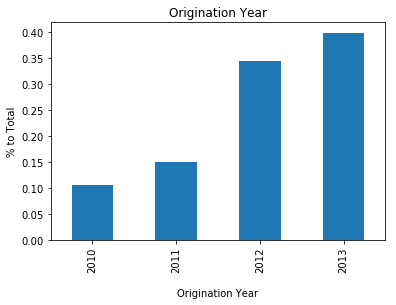

In [16]:
histogram(distr_dict['ory'], 'Origination Year')

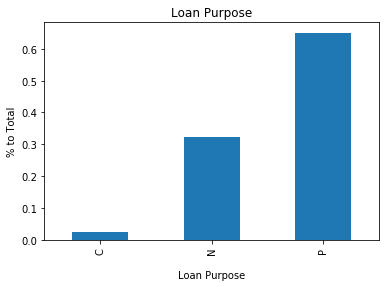

In [17]:
histogram(distr_dict['loan_purp'], 'Loan Purpose')

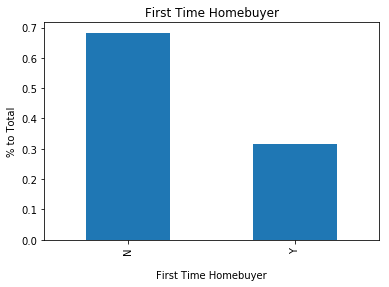

In [18]:
histogram(distr_dict['fhb_flag'], 'First Time Homebuyer')

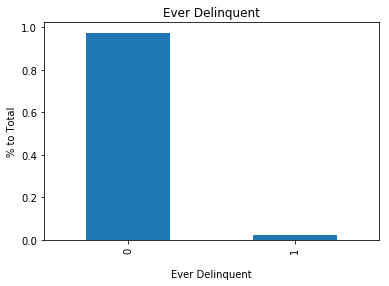

In [19]:
histogram(distr_dict['Ever_Delinquent'], 'Ever Delinquent')

In [20]:
# Alternative way to create histogram method using feature as parameter
def histogram_alt(feature):
    df = distr_dict[feature]
    title_name = feature.split('_', 1)[0].upper()
    return df.plot(kind='bar', title=title_name).set(xlabel=title_name, ylabel='% to Total')

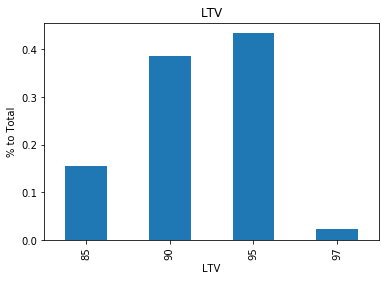

In [21]:
histogram_alt('ltv_new')

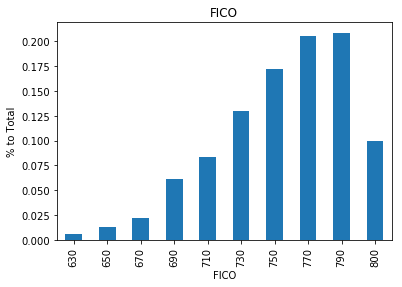

In [22]:
histogram_alt('FICO_new')

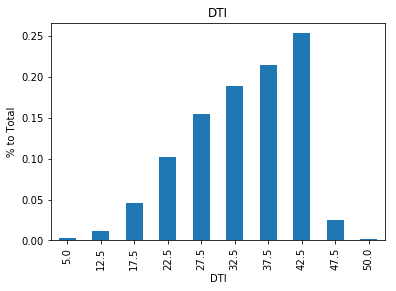

In [23]:
histogram_alt('dti_new')

**Due to unbalanced target data, we will need to upsample or downsample one of the class. Here I chose to downsample never deliquenty loans** 
 - Select 10,000 per group (Ever Delinquent)

In [24]:
target_col_name = 'Ever_Delinquent'
sample_size = 10000
df_new =df.groupby(target_col_name,as_index=False).apply(lambda x: x.sample(sample_size)).reset_index()

In [25]:
df_new.groupby(target_col_name).loan_id.nunique()

Ever_Delinquent
0    10000
1    10000
Name: loan_id, dtype: int64

### Selected Features
- **Loan Purpose**: loan_purp 
- **Property Type**: prop_type
- **Occupancy Status**: occ_stat
- **DTI**: dti_new
- **FICO**: FICO_new
- **LTV**: ltv_new
- **First Time Home Buyer Indicator**: fhb_flag
- **MI Channel**: MI_chl
- **Number of Borrower**: no_bor
- **Origination Year**: ory

### Target : Ever Delinquent (Y/N)

In [26]:
# Create a new DataFrame to just include selected features and target
selected_col_name = ['loan_purp', 'prop_type', 'occ_stat', 'dti_new',
                     'FICO_new', 'ltv_new', 'fhb_flag', 'MI_chl',
                     'no_bor','ory','Ever_Delinquent']
df_model = df_new[selected_col_name]

In [27]:
df_model.head()

,loan_purp,prop_type,occ_stat,dti_new,FICO_new,ltv_new,fhb_flag,MI_chl,no_bor,ory,Ever_Delinquent
0,P,SF,O,27.5,710,85,N,Delegated,1,2013,0
1,P,SF,O,37.5,790,95,N,Delegated,2,2013,0
2,N,SF,O,27.5,750,85,N,Delegated,2,2012,0
3,N,SF,O,32.5,790,90,N,Non-Delegated,2,2012,0
4,N,SF,O,27.5,800,90,N,Non-Delegated,2,2012,0


Split table into "target" vs. "features"

In [28]:
X = df_model.iloc[:,0:-1].values
y = df_model.iloc[:,-1].values

**Encode Categorical Columns**
- Use LabelEncoder to transform categorical columns to numeric value, and then use OneHotEncoder to get dummy variable
- Create dummy variables for fields which have more than 2 values

In [29]:
feature_ls = ['loan_purp', 'prop_type', 'occ_stat', 'dti_new', 'FICO_new', 
              'ltv_new', 'fhb_flag', 'MI_chl', 'no_bor','ory'
             ]
              
df_X = pd.DataFrame(X, columns = feature_ls)

# Create dummy variable and drop one value for each feature
df_X_dummy = pd.get_dummies(df_X, drop_first=True).astype(np.int64)

In [30]:
df_X_dummy.shape

(20000, 32)

In [31]:
df_X_dummy.head()

,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,dti_new_32.5,...,FICO_new_800,ltv_new_90,ltv_new_95,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,1,0
4,1,0,0,1,0,0,0,0,1,0,...,1,1,0,0,0,1,1,0,1,0


In [32]:
# FICO related fields list - used to create model threshold
df_X_FICO = df_X_dummy[['FICO_new_650', 'FICO_new_670', 'FICO_new_690',
                        'FICO_new_710', 'FICO_new_730', 'FICO_new_750',
                        'FICO_new_770', 'FICO_new_790', 'FICO_new_800'
                       ]]

# Change the transformed dataframe to array
X = df_X_dummy.as_matrix()
X_FICO = df_X_FICO.as_matrix()

In [33]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_FICO_train, X_FICO_test, y_FICO_train, y_FICO_test = train_test_split(X_FICO, y, test_size = 0.2, random_state = 0)

**Creating Threshold Based on FICO Only Prediction**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clf_thresh = LogisticRegression(random_state = 0)
clf_thresh.fit(X_FICO_train, y_FICO_train)
y_FICO_pred = clf_thresh.predict(X_FICO_test)
print('ROC AUC Score Threshold is %s' % (roc_auc_score(y_FICO_test, y_FICO_pred)))

ROC AUC Score Threshold is 0.644409549686


In [35]:
from sklearn.model_selection import cross_val_score
accuracies_thresh = cross_val_score(estimator = clf_thresh, X = X_FICO_train, y = y_FICO_train, cv = 10)
print ('Mean of Threshold Accuracy is %s' % (accuracies_thresh.mean()))
print ('Std of Threshold Accuracy is %s' % (accuracies_thresh.std()))

Mean of Threshold Accuracy is 0.651624109472
Std of Threshold Accuracy is 0.00855470042834


#### Applying Different Classifiers on Training Dataset

In [36]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Create a list of classifiers
classifiers = [LogisticRegression(random_state = 0),
               SVC(kernel = "linear", random_state = 0),
               SVC(kernel = "poly", random_state = 0),
               RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0),
               DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
               KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2),
               
              ]

classifier_name = ['LogisticReg', 'SVM', 'SVM Kernel', 'Random Forest', 'Decision Tree', 'K-NN']

In [37]:
classifier_dict = {'LogisticReg': LogisticRegression(random_state = 0),
                   'SVM': SVC(kernel = "linear", random_state = 0),
                   'SVM Kernel': SVC(kernel = "poly", random_state = 0),
                   'Random Forest': RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0),
                   'Decision Tree': DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
                   'KNN': KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
                  }

In [38]:
performance_dict = {}

for clf in classifiers:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    performance_dict[clf] = [roc_auc_score(y_test, pred)]

pd.DataFrame(performance_dict)

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)","SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape=None, degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001, verbose=False)","SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape=None, degree=3, gamma='auto', kernel='poly', max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001, verbose=False)","(DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=209652396, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=398764591, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=924231285, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=1478610112, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=441365315, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=1537364731, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=192771779, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=1491434855, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=1819583497, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=530702035, splitter='best'))","DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=0, splitter='best')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform')"
0,0.669047,0.64441,0.648288,0.618982,0.617394,0.611497


In [39]:
# Alternative Way to Show roc_auc_score

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('SVMKernel', SVC(kernel = "poly")))
models.append(('RF', RandomForestClassifier()))

In [40]:
results = []
names = []
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, pred)
    #results.append(roc_auc)
    #names.append(name)
    #msg = "%s: %f" % (name, roc_auc_score)

LR: 0.685813 (0.009186)
LDA: 0.686562 (0.007149)
KNN: 0.636563 (0.008787)
CART: 0.621438 (0.009010)
NB: 0.651250 (0.006829)
SVM: 0.660937 (0.009899)
SVMKernel: 0.661625 (0.014804)
RF: 0.629125 (0.007737)


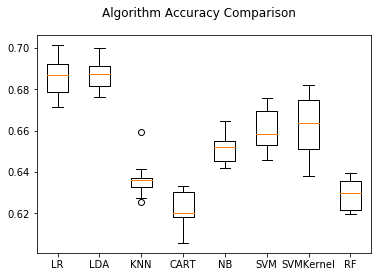

In [41]:
# prepare configuration for cross validation test harness
seed = 7

# Compare accuracy score among different models
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.747149 (0.008767)
LDA: 0.747257 (0.008894)
KNN: 0.669877 (0.008380)
CART: 0.636602 (0.008466)
NB: 0.703758 (0.009167)
SVM: 0.731584 (0.010260)
SVMKernel: 0.721638 (0.013174)
RF: 0.674122 (0.009621)


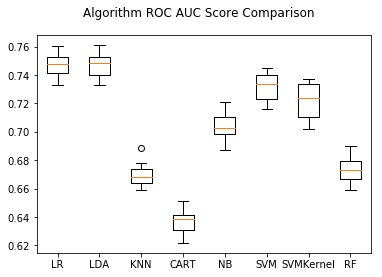

In [42]:
# Compare roc auc score among different models
results_auc = []
names = []
scoring_auc = 'roc_auc'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results_auc = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring_auc)
	results_auc.append(cv_results_auc)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results_auc.mean(), cv_results_auc.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm ROC AUC Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_auc)
ax.set_xticklabels(names)
plt.show()

### Find out the probablity of loan in claim with the ever deliquent status

In [43]:
(df[df['claim_flag'] == 1]
  .groupby('Ever_Delinquent')
  .loan_id.nunique()/df.groupby('Ever_Delinquent').loan_id.nunique()
).mul(100).round(1).astype(str) + '%'

Ever_Delinquent
0    nan%
1    8.4%
Name: loan_id, dtype: object

### Perform Regularization On Logistic Regression Classifier

In [44]:
l1_penalty = [0, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 50, 60, 80, 90, 100]
regularization_dic = {}

for penalty_param in l1_penalty:
    clf = LogisticRegression(penalty = 'l1', C = penalty_param)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
regularization_dic[penalty_param] = roc_auc_score(y_test, y_pred)

In [55]:
regularization_dic

{100: 0.66980177821600395}

In [45]:
for penalty_param in l1_penalty:
    clf  = LogisticRegression(penalty = 'l1', C = penalty_param)
clf.fit(X_train, y_train)
roc_auc = model_selection.cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'roc_auc')
msg = "%s: %f (%f)" % (penalty_param, roc_auc.mean(), roc_auc.std())
print(msg)

100: 0.747251 (0.009085)


In [46]:
# Predicting the Test set results
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [47]:
# Return the probablity of "1" class to training set and test set
y_hats_train = clf.predict(X_train)
delinquent_proba_train = clf.predict_proba(X_train)[:,1]
df_train = pd.DataFrame(X_train, columns = df_X_dummy.columns)
df_train.loc[:,'y_actual'] = y_train
df_train.loc[:,'y_hats'] = y_hats_train
df_train.loc[:,'delinquent_proba'] = delinquent_proba_train

In [48]:
y_hats_test = clf.predict(X_test)
delinquent_proba_test = clf.predict_proba(X_test)[:,1]
df_test = pd.DataFrame(X_test)
df_test.loc[:,'y_actual'] = y_test
df_test.loc[:,'y_hats'] = y_hats_test
df_test.loc[:,'delinquent_proba'] = delinquent_proba_test

In [49]:
df_train.head()

,loan_purp_N,loan_purp_P,prop_type_MH,prop_type_SF,occ_stat_S,dti_new_12.5,dti_new_17.5,dti_new_22.5,dti_new_27.5,dti_new_32.5,...,ltv_new_97,fhb_flag_Y,MI_chl_Non-Delegated,no_bor_2,ory_2011,ory_2012,ory_2013,y_actual,y_hats,delinquent_proba
0,0,1,0,1,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0.675195
1,0,1,0,1,1,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0.331910
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.208875
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.716050
4,1,0,0,1,0,0,0,0,1,0,...,0,0,1,1,1,0,0,0,0,0.219274


y_hats
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: delinquent_proba, dtype: object

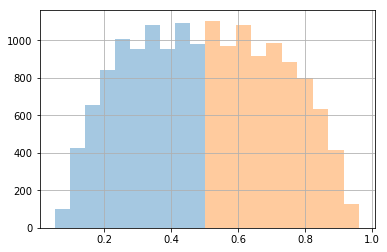

In [50]:
df_train.groupby("y_hats").delinquent_proba.hist(alpha=0.4)

y_hats
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: delinquent_proba, dtype: object

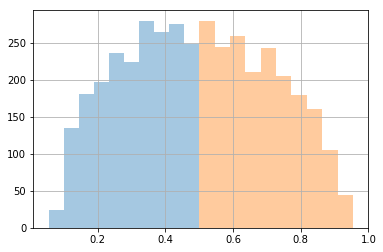

In [51]:
df_test.groupby("y_hats").delinquent_proba.hist(alpha=0.4)

y_actual
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: delinquent_proba, dtype: object

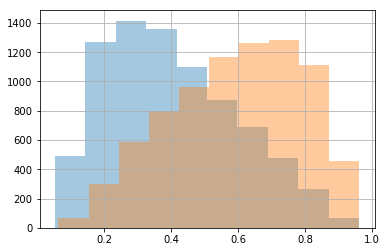

In [52]:
df_train.groupby("y_actual").delinquent_proba.hist(alpha=0.4)

y_actual
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: delinquent_proba, dtype: object

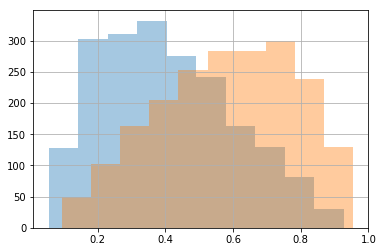

In [53]:
df_test.groupby("y_actual").delinquent_proba.hist(alpha=0.4)

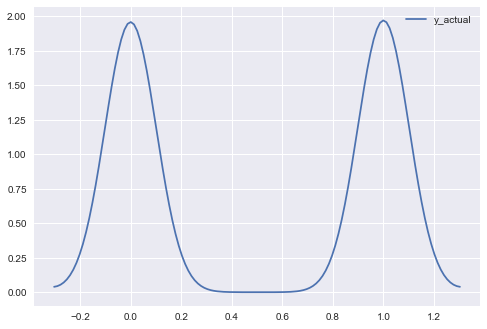

In [54]:
import seaborn as sns
sns.kdeplot(df_test.y_actual)  